In [1]:
# Imports
import itertools
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV, LinearRegression, LogisticRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

# HES wrangling + analysis challenge

# 1. Load data

First, we load all the necessary files into pandas dataframes (__data parsing__). There are several interesting operations here:

1 - Among all the existing files, only a subset of the data and several files are loaded. A __data dictionary__ process was performed previous to the parsing, to select what to load.

2 - `appliance_group_data-1a.csv` does not contain headers, so a process of __data dictionary__ was necessary to understand the meaning of the features in the data

In [2]:
# ADD your data path here!
data_path = "../../../HES/"

#Appliances type codes
df_appliance_type_codes = pd.read_csv(os.path.join(data_path, "small/appliance_type_codes.csv"))
df_appliance_type_codes.head()

,Code,Name
0,1001,Cold appliances
1,1002,Cooking
2,1003,Lighting
3,1004,Audiovisual
4,1005,ICT


In [3]:
# Appliances types
df_appliance_types = pd.read_csv(os.path.join(data_path, "small/appliance_types.csv"))
df_appliance_types.head()

,ApplianceCode,GroupCode
0,0,1001
1,1,1001
2,2,1001
3,3,1001
4,4,1001


In [4]:
#Appliances codes
df_appliance_codes = pd.read_csv(os.path.join(data_path, "small/appliance_codes.csv"))
df_appliance_codes.head()

,Code,Name
0,0,upright freezer 1
1,1,upright freezer 2
2,2,chest freezer 1
3,3,chest freezer 2
4,4,fridge 1


In [5]:
#Add headers to profiles
df_profiles = pd.read_csv(os.path.join(data_path, "agd-1a/appliance_group_data-1a.csv"),
                    header=None,
                    names=['IntervalID','Household','ApplianceCode','DateRecorded','Data','TimeRecorded'])
df_profiles.head()

,IntervalID,Household,ApplianceCode,DateRecorded,Data,TimeRecorded
0,1,202116,0,2010-07-28,0,00:00:00
1,1,202116,0,2010-07-28,0,00:02:00
2,1,202116,0,2010-07-28,0,00:04:00
3,1,202116,0,2010-07-28,0,00:06:00
4,1,202116,0,2010-07-28,0,00:08:00


3 - A minor __canonicalization__ problem arises with the headers. Some of the header names contain white spaces in them, that need to be removed.

In [6]:
# clean column headers
print(df_appliance_types.columns)
df_appliance_types.columns = df_appliance_types.columns.str.strip()
print(df_appliance_types.columns)

Index(['ApplianceCode', ' GroupCode'], dtype='object')
Index(['ApplianceCode', 'GroupCode'], dtype='object')


# 2. Record linkage 

An involved __data integration__ problem arises with these files. df_profiles contain an `appliance_code` feature that referes to the type of appliance of the measurement. In df_appliance_types, an `appliance_code` is linked to a `group_code`, and in df_appliance_type_codes a `group_code` is linked to a `group_name`. The final objective of the linking process is to associate each measurement to a `group_name`, so several liking operations across csv files are necessary.

The primary key identification was done manually, and furthermore, the `appliance_code` header in profiles didn't exists, so the analyst manually identified this feature as a primary key without a name on the header.

Additionally, there's a further step of __missing data__ identification, where appliance codes associated to terms like 'Unknown' or 'Other' are removed from the dataframe.

In [7]:
# Record linkage operations (link types with type_codes)
df_appliance_types = df_appliance_types.merge(
    df_appliance_type_codes,
    left_on="GroupCode",
    right_on="Code"
)
df_appliance_types.head()

,ApplianceCode,GroupCode,Code,Name
0,0,1001,1001,Cold appliances
1,1,1001,1001,Cold appliances
2,2,1001,1001,Cold appliances
3,3,1001,1001,Cold appliances
4,4,1001,1001,Cold appliances


In [8]:
#Remove Unknown and Other (present in Name), afterwards, remove Name and Code features
df_appliance_types = df_appliance_types.loc[
    ~df_appliance_types["Name"].isin(["Other", "Unknown"]),
    ["ApplianceCode", "GroupCode"]
]
df_appliance_types.head()

,ApplianceCode,GroupCode
0,0,1001
1,1,1001
2,2,1001
3,3,1001
4,4,1001


In [9]:
#Join profiles and types (primary key: ApplianceCode)
df_profiles = df_profiles.merge(df_appliance_types, how='left', on='ApplianceCode')
df_profiles.head()

,IntervalID,Household,ApplianceCode,DateRecorded,Data,TimeRecorded,GroupCode
0,1,202116,0,2010-07-28,0,00:00:00,1001.0
1,1,202116,0,2010-07-28,0,00:02:00,1001.0
2,1,202116,0,2010-07-28,0,00:04:00,1001.0
3,1,202116,0,2010-07-28,0,00:06:00,1001.0
4,1,202116,0,2010-07-28,0,00:08:00,1001.0


# 3. Drop rows with temperature readings

Here, we remove all instances where `GroupCode` is missing. Notice that, by removing the `Other` and `Unknown` names during the integration, we effectively introduce Null entries in our data.

This is an example of __data transformation__ due to __missing data__.

In [10]:
temp_rows = df_profiles[df_profiles['GroupCode'].isnull()].index
df_profiles.drop(temp_rows, inplace=True)

# 4. Demographic data

Here we load a different csv with demographic info about the different households and appliances in each household (__data parsing__). From the original 103 features in the data, only a subset of 10 features in the data are used for the experiments (__data transformation__).

In [11]:
# ADD your data path here!
df_feat = pd.read_csv(os.path.join(data_path,"anonhes/ipsos-anonymised-corrected_310713.csv"))
df_feat = df_feat[
    ["Household",
    "HouseholdOccupancy",
    "SinglePensioner",
    "SingleNonPensioner",
    "MultiplePensioner",
    "HouseholdWithChildren",
    "MultiplePersonWithNoDependentChildren",
    "HouseholdType",
    "House.age",
    "Social.Grade"]
]
df_feat.head()

,Household,HouseholdOccupancy,SinglePensioner,SingleNonPensioner,MultiplePensioner,HouseholdWithChildren,MultiplePersonWithNoDependentChildren,HouseholdType,House.age,Social.Grade
0,101006,5,0,0,0,0,1,5,1991-1995,B
1,101007,2,0,0,0,0,1,5,1930-1949,E
2,101009,2,0,0,1,0,0,3,1950-1966,A
3,101010,4,0,0,0,1,0,4,1950-1966,C1
4,101017,1,1,0,0,0,0,1,1967-1975,C2


# 5. Wrangling steps on demographics data

In the `HouseholdOccupancy` column, the occupancy is recorded for up to 6 people, and for more than this it is recorded as "6+". As a simple fix for this, we replace "6+" with 6, and cast the column to `int`.

Note that, category 6 does not exist, so it is not possible to distiguish between 6 and more than 6 (__canonicalization__)

In [12]:
df_feat["HouseholdOccupancy"].unique()

array(['5', '2', '4', '1', '6+', '3'], dtype=object)

In [13]:
# Fix household occupancy column
df_feat.loc[:, "HouseholdOccupancy"] = df_feat[
    "HouseholdOccupancy"
].str.replace("+", "").astype(int)
df_feat["HouseholdOccupancy"].unique()

array([5, 2, 4, 1, 6, 3])

`PensionerOnly` feature: 0 if anyone who lives in the house is not a pensioner, 1 otherwise.
If we create this feature, we can remove several others and reduce redundancy.

We combine `SinglePensioner` and `MultiplePensioner` into a single feature `PensionerOnly` (__FE__)

In [14]:
# Make pensioner only feature
df_feat.loc[:, "PensionerOnly"] = (
    df_feat["SinglePensioner"] | df_feat["MultiplePensioner"]
).astype(int)

`HouseholdType` is a redundant feature, it is basically the code of the other 5 categories in the header (__DT__).
So is `MultiplePersonWithNoDependentChildren`, and the pensioner features (after creating the `PensionerOnly` feature). We remove all redundant columns.

In [15]:
# Drop redundant features
df_feat = df_feat.drop(labels=["HouseholdType",
                               "MultiplePersonWithNoDependentChildren",
                               "SinglePensioner",
                               "MultiplePensioner",
                               "SingleNonPensioner"]
                       , axis=1)
df_feat.head()

,Household,HouseholdOccupancy,HouseholdWithChildren,House.age,Social.Grade,PensionerOnly
0,101006,5,0,1991-1995,B,0
1,101007,2,0,1930-1949,E,0
2,101009,2,0,1950-1966,A,1
3,101010,4,1,1950-1966,C1,0
4,101017,1,0,1967-1975,C2,1


`Social.Grade` is an ordinal feature with 6 values, where the only missing value is imputed using the mode (__feature engineering__ + __missing data__)

In [16]:
# Social grade feature
social_cats = np.sort(df_feat["Social.Grade"].dropna().unique())
print(social_cats)

['A' 'B' 'C1' 'C2' 'D' 'E']


In [17]:
df_feat = df_feat.replace(
    to_replace={
        "Social.Grade": {v: int(i) for i, v in enumerate(social_cats)}
    }
)
df_feat.loc[:, "Social.Grade"] = df_feat.loc[:, "Social.Grade"].fillna(
    df_feat["Social.Grade"].value_counts().index[0]
)
df_feat.loc[:, "Social.Grade"] = df_feat.loc[:, "Social.Grade"].astype(int)
df_feat.head()

,Household,HouseholdOccupancy,HouseholdWithChildren,House.age,Social.Grade,PensionerOnly
0,101006,5,0,1991-1995,1,0
1,101007,2,0,1930-1949,5,0
2,101009,2,0,1950-1966,0,1
3,101010,4,1,1950-1966,2,0
4,101017,1,0,1967-1975,3,1


The `House.age` column is a string, e.g. "1950-1966". We convert this to a number by taking the midpoint of the range. There are some missing values set to `-1`, which we replace with the most common value.

In [18]:
df_feat['House.age'].value_counts()

1950-1966       56
1930-1949       43
1900-1929       41
Before 1900     27
1967-1975       25
1983-1990       15
1996-2002       13
1991-1995       12
1976-1982        7
2003-2006        6
-1               4
2007 onwards     2
Name: House.age, dtype: int64

There seem to be some predefined ranges of ages in the houses, so this could have been coded as well as an ordinal feature. (__FE__ + __MD__). Notice that there are two special cases: "Before 1900" and "2007 onwards". In both cases, we encode them by 2010 minuns the defined year (1900, and 2007)

In [19]:
# Age of house
def get_age(yrs):
    if yrs == '-1':
        return get_age("1950-1966")
    elif yrs == 'Before 1900':
        yr = 1900
    elif yrs == '2007 onwards':
        yr = 2007
    else:
        start, end = [int(i) for i in yrs.split('-')]
        yr = start + (end - start) // 2
    return 2010 - yr

In [20]:
df_feat.loc[:, "House.age"] = df_feat["House.age"].apply(get_age)

In [21]:
df_feat.head()

,Household,HouseholdOccupancy,HouseholdWithChildren,House.age,Social.Grade,PensionerOnly
0,101006,5,0,17,1,0
1,101007,2,0,71,5,0
2,101009,2,0,52,0,1
3,101010,4,1,52,2,0
4,101017,1,0,39,3,1


# 6. Creation of data and target variables

In [22]:
df_profiles.head()

,IntervalID,Household,ApplianceCode,DateRecorded,Data,TimeRecorded,GroupCode
0,1,202116,0,2010-07-28,0,00:00:00,1001.0
1,1,202116,0,2010-07-28,0,00:02:00,1001.0
2,1,202116,0,2010-07-28,0,00:04:00,1001.0
3,1,202116,0,2010-07-28,0,00:06:00,1001.0
4,1,202116,0,2010-07-28,0,00:08:00,1001.0


There's a two step process here:

1. The data is grouped according to the household, the recording date and the groupcode, and the data is sum across each group to create the target variable y (__data integration__)

In [23]:
# make table of power consumption in each appliance group per house on each day
df_y = df_profiles.groupby(
    ['Household', 'DateRecorded', 'GroupCode']
)["Data"].sum().unstack("GroupCode").stack(dropna=False)

In [24]:
df_y.head()

Household  DateRecorded  GroupCode
201103     2010-06-17    1001.0       50888.0
                         1002.0       15448.0
                         1003.0           NaN
                         1004.0        5042.0
                         1005.0           NaN
dtype: float64

2. df_feat (demographic data) is linked to this new dataframe by using `Household` as the primary key. The data across the groupCodes in a given date is summed, and recoded in `TotalUsage`. (__DT__)

In [25]:
# make features table
df_X = df_y.groupby(
    ["Household", "DateRecorded"]
).sum().reset_index().merge(
    df_feat,
    how="inner",
    left_on="Household",
    right_on="Household"
).rename(columns={0: "TotalUsage"})

In [26]:
df_X.head()

,Household,DateRecorded,TotalUsage,HouseholdOccupancy,HouseholdWithChildren,House.age,Social.Grade,PensionerOnly
0,201103,2010-06-17,96796.0,2,0,52,3,0
1,201103,2010-06-18,106954.0,2,0,52,3,0
2,201103,2010-06-19,111205.0,2,0,52,3,0
3,201103,2010-06-20,82933.0,2,0,52,3,0
4,201103,2010-06-21,119564.0,2,0,52,3,0


# 7. Feature engineering in data and target

`DateRecorded` is transformed into a datetime, and the weekday and month are added as features. For the weekday, a one hot encodding is employed (__FE__)

In [27]:
df_X["dt"] = pd.to_datetime(df_X['DateRecorded'])
df_X["dow"] = df_X["dt"].dt.day_name()
df_X["month"] = df_X["dt"].dt.month
df_X = df_X.drop(labels=["dt"], axis=1).set_index(
    ["Household", "DateRecorded"]
)
df_X = pd.concat(
    (df_X, pd.get_dummies(df_X["dow"])), axis=1
).drop(labels=["dow"],axis=1)

In [28]:
df_X.head()

TotalUsage  HouseholdOccupancy  HouseholdWithChildren  \
Household DateRecorded                                                          
201103    2010-06-17       96796.0                   2                      0   
          2010-06-18      106954.0                   2                      0   
          2010-06-19      111205.0                   2                      0   
          2010-06-20       82933.0                   2                      0   
          2010-06-21      119564.0                   2                      0   

                        House.age  Social.Grade  PensionerOnly  month  Friday  \
Household DateRecorded                                                          
201103    2010-06-17           52             3              0      6       0   
          2010-06-18           52             3              0      6       1   
          2010-06-19           52             3              0      6       0   
          2010-06-20           52             3              0      6       0   
          2010-06-21           52             3              0      6       0   

                        Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  
Household DateRecorded                                                          
201103    2010-06-17         0         0       0         1        0          0  
          2010-06-18         0         0       0         0        0          0  
          2010-06-19         0         1       0         0        0          0  
          2010-06-20         0         0       1         0        0          0  
          2010-06-21         1         0       0         0        0          0

A dataframe is created with the energy consumption per groupCode for each household and date. The data is recorded as log(1+x).

In [29]:
# make table of usage per appliance group
df_y = df_y.reset_index().merge(
    df_X.reset_index(),
    how="inner",
    left_on=["Household", "DateRecorded"],
    right_on=["Household", "DateRecorded"]
)[["Household", "DateRecorded", "GroupCode", 0, "TotalUsage"]]
df_y.loc[:, 0] = np.log1p(df_y[0]) # log transform usage
df_y = df_y.drop(labels=["TotalUsage"], axis=1)
df_y = df_y.set_index(
    ["Household", "DateRecorded"]
).pivot(columns="GroupCode")[0]

In [30]:
df_y.head()

GroupCode                  1001.0     1002.0  1003.0    1004.0  1005.0  \
Household DateRecorded                                                   
201103    2010-06-17    10.837402   9.645300     NaN  8.525756     NaN   
          2010-06-18    10.852555   9.661352     NaN  8.567126     NaN   
          2010-06-19    10.884067   9.790039     NaN  8.883779     NaN   
          2010-06-20    10.769705  10.139231     NaN  9.216422     NaN   
          2010-06-21    10.823750   9.938662     NaN  8.920122     NaN   

GroupCode                 1006.0  1007.0  1008.0     1013.0  
Household DateRecorded                                       
201103    2010-06-17    0.000000     NaN     NaN  10.143252  
          2010-06-18    8.880864     NaN     NaN  10.208948  
          2010-06-19    8.302018     NaN     NaN  10.267749  
          2010-06-20    0.000000     NaN     NaN   0.000000  
          2010-06-21    8.297045     NaN     NaN  10.523015

Three fourier components are created for each household and date, according to the month when the measurements were done (__FE__). Also, `month` feature is dropped

In [31]:
# fourier features
def make_fourier_features(t, order=2):
    # ripped off from fbprophet
    return np.column_stack([
        trig((2.0 * (i + 1) * np.pi * t / 12))
        for i in range(order)
        for trig in (np.sin, np.sin)
    ])

fourier_feats = np.array(
    [make_fourier_features(t) for t in df_X["month"].values]
)[:, 0, :]
for i in range(fourier_feats.shape[1]):
    df_X["fourier"+str(i)] = fourier_feats[:, i]
df_X = df_X.drop(labels=["month"], axis=1)

In [32]:
df_X.head()

TotalUsage  HouseholdOccupancy  HouseholdWithChildren  \
Household DateRecorded                                                          
201103    2010-06-17       96796.0                   2                      0   
          2010-06-18      106954.0                   2                      0   
          2010-06-19      111205.0                   2                      0   
          2010-06-20       82933.0                   2                      0   
          2010-06-21      119564.0                   2                      0   

                        House.age  Social.Grade  PensionerOnly  Friday  \
Household DateRecorded                                                   
201103    2010-06-17           52             3              0       0   
          2010-06-18           52             3              0       1   
          2010-06-19           52             3              0       0   
          2010-06-20           52             3              0       0   
          2010-06-21           52             3              0       0   

                        Monday  Saturday  Sunday  Thursday  Tuesday  \
Household DateRecorded                                                
201103    2010-06-17         0         0       0         1        0   
          2010-06-18         0         0       0         0        0   
          2010-06-19         0         1       0         0        0   
          2010-06-20         0         0       1         0        0   
          2010-06-21         1         0       0         0        0   

                        Wednesday      fourier0      fourier1      fourier2  \
Household DateRecorded                                                        
201103    2010-06-17            0  1.224647e-16  1.224647e-16 -2.449294e-16   
          2010-06-18            0  1.224647e-16  1.224647e-16 -2.449294e-16   
          2010-06-19            0  1.224647e-16  1.224647e-16 -2.449294e-16   
          2010-06-20            0  1.224647e-16  1.224647e-16 -2.449294e-16   
          2010-06-21            0  1.224647e-16  1.224647e-16 -2.449294e-16   

                            fourier3  
Household DateRecorded                
201103    2010-06-17   -2.449294e-16  
          2010-06-18   -2.449294e-16  
          2010-06-19   -2.449294e-16  
          2010-06-20   -2.449294e-16  
          2010-06-21   -2.449294e-16

Numerical features are scaled by their range (diff between the max and min of the feature) (__FE__)

In [33]:
# standardise columns where appropriate
# for column in ["TotalUsage", "House.age", "HouseholdOccupancy", "Social.Grade"]:
for column in ["TotalUsage", "House.age"]:
    scaler = MinMaxScaler()
    val_scaled = scaler.fit_transform(df_X[column].values.reshape(-1, 1))
    df_X.loc[:, column] = val_scaled
    
for column in df_y.columns:
    scaler = MinMaxScaler()
    val_scaled = scaler.fit_transform(df_y[column].fillna(0.).values.reshape(-1, 1))
    df_y.loc[:, column] = val_scaled  

In [34]:
df_y.head()

GroupCode                 1001.0    1002.0  1003.0    1004.0  1005.0  \
Household DateRecorded                                                 
201103    2010-06-17    0.958271  0.814067     0.0  0.784725     0.0   
          2010-06-18    0.959611  0.815422     0.0  0.788533     0.0   
          2010-06-19    0.962397  0.826283     0.0  0.817678     0.0   
          2010-06-20    0.952285  0.855755     0.0  0.848295     0.0   
          2010-06-21    0.957064  0.838827     0.0  0.821023     0.0   

GroupCode                 1006.0  1007.0  1008.0    1013.0  
Household DateRecorded                                      
201103    2010-06-17    0.000000     0.0     0.0  0.886937  
          2010-06-18    0.728671     0.0     0.0  0.892682  
          2010-06-19    0.681177     0.0     0.0  0.897823  
          2010-06-20    0.000000     0.0     0.0  0.000000  
          2010-06-21    0.680769     0.0     0.0  0.920144

Create two matrices X and y for modelling. y contains the energy consumption per groupCode and 3 fourier components (1,2,3). X contains the demographics data and the total energy consumption

In [35]:
# prepare data for modelling
df_all = df_X.merge(df_y, left_index=True, right_index=True)
X = df_all[df_all.columns[:-13]].values
y = df_all[df_all.columns[-1:-13:-1]].values

In [36]:
df_all.head()

TotalUsage  HouseholdOccupancy  HouseholdWithChildren  \
Household DateRecorded                                                          
201103    2010-06-17      0.210614                   2                      0   
          2010-06-18      0.232717                   2                      0   
          2010-06-19      0.241966                   2                      0   
          2010-06-20      0.180450                   2                      0   
          2010-06-21      0.260154                   2                      0   

                        House.age  Social.Grade  PensionerOnly  Friday  \
Household DateRecorded                                                   
201103    2010-06-17     0.457944             3              0       0   
          2010-06-18     0.457944             3              0       1   
          2010-06-19     0.457944             3              0       0   
          2010-06-20     0.457944             3              0       0   
          2010-06-21     0.457944             3              0       0   

                        Monday  Saturday  Sunday  ...      fourier3    1001.0  \
Household DateRecorded                            ...                           
201103    2010-06-17         0         0       0  ... -2.449294e-16  0.958271   
          2010-06-18         0         0       0  ... -2.449294e-16  0.959611   
          2010-06-19         0         1       0  ... -2.449294e-16  0.962397   
          2010-06-20         0         0       1  ... -2.449294e-16  0.952285   
          2010-06-21         1         0       0  ... -2.449294e-16  0.957064   

                          1002.0  1003.0    1004.0  1005.0    1006.0  1007.0  \
Household DateRecorded                                                         
201103    2010-06-17    0.814067     0.0  0.784725     0.0  0.000000     0.0   
          2010-06-18    0.815422     0.0  0.788533     0.0  0.728671     0.0   
          2010-06-19    0.826283     0.0  0.817678     0.0  0.681177     0.0   
          2010-06-20    0.855755     0.0  0.848295     0.0  0.000000     0.0   
          2010-06-21    0.838827     0.0  0.821023     0.0  0.680769     0.0   

                        1008.0    1013.0  
Household DateRecorded                    
201103    2010-06-17       0.0  0.886937  
          2010-06-18       0.0  0.892682  
          2010-06-19       0.0  0.897823  
          2010-06-20       0.0  0.000000  
          2010-06-21       0.0  0.920144  

[5 rows x 26 columns]

# Modelling: Energy usage of houses

We attempt to predict the quantity of energy from a given household

In [37]:
# split the houses into train/test sets
houses = df_all.reset_index()["Household"].unique()
houses_train, houses_test = train_test_split(houses, random_state=2)

# use the above train/test houses to create train/test dataframes
df_train = df_all.reset_index()[
    df_all.reset_index()["Household"].isin(houses_train)
].set_index(["Household", "DateRecorded"])
df_test = df_all.reset_index()[
    df_all.reset_index()["Household"].isin(houses_test)
].set_index(["Household", "DateRecorded"])


def get_X_y(df):
    # create X and y arrays for scikit learn from dataframes
    X = df[df.columns[:-9]].values
    y = df[df.columns[-1:-10:-1]].values
    return X, y

X_train, y_train = get_X_y(df_train)
X_test, y_test = get_X_y(df_test)

# drop columns with all zeros
ind = np.copy(~np.all(y_test == 0, axis=0))
y_train = y_train[:, ind]
y_test = y_test[:, ind]
appliances = df_appliance_type_codes.set_index("Code").loc[
    df_all[df_all.columns[-1:-10:-1]].columns[ind],
    "Name"
].values

In [38]:
def train_models(X_train, y_train):
    """A simple model that first classifies the measurement as being 0 or non zero, then 
    predicts the non-zero values."""
    
    # train classifier to detect zeros
    y_bin = np.copy(y_train)
    y_bin[y_bin != 0.0] = 1.0
    clf = RandomForestClassifier(
        class_weight="balanced_subsample",
        random_state=42
    )
    clf.fit(X_train, y_bin)
    
    # train regression to predict non-zero values
    # have to do this separately for each of the outputs
    y_reg = np.copy(y_train)
    X_reg = np.copy(X_train)
    regressors = dict()
    for i in range(y_reg.shape[1]):
        regressors[i] = ElasticNetCV(
            random_state=42
        )
        y_i = y_reg[:, i]
        ind = y_i != 0
        X_i = X_reg[ind, :]
        y_i = y_i[ind]
        regressors[i].fit(X_i, y_i)
    
    return (clf, regressors)


def predict(X_test, clf, regressors):
    """Given a classifier and set of regressors, produce predictions."""
    y_bin = clf.predict(X_test)
    
    y_pred = np.copy(y_bin)
    for i in range(y_bin.shape[1]):
        y_i = y_pred[:, i]
        ind = y_i != 0
        if ind.sum() != 0:
            y_pred[ind, i] = regressors[i].predict(X_test[ind, :])
    
    return y_bin, y_pred

In [39]:
# fit the models and predict on the test set
clf, regressors = train_models(X_train, y_train)
y_bin, y_pred = predict(X_test, clf, regressors)
y_baseline = np.repeat(y_train.mean(axis=0)[:, None], y_test.shape[0], axis=1).T

print(
    "Model average absolute error = {:.4f}".format(
        mean_absolute_error(y_test, y_pred)
    )
)
print(
    "Baseline average absolute error = {:.4f}".format(
        mean_absolute_error(y_test, y_baseline)
    )
)

Model average absolute error = 0.1453
Baseline average absolute error = 0.2087


In [40]:
(y_bin == (y_test != 0)).mean()

0.8370911107004251

The model beats the very naive baseline of the mean of each column. Instead, we try a different baseline that mimics the more sophisticated model. It will assign a nonzero value at random to each entry in `y` using a binomial distribution with rate set by the fraction of nonzero entries in that column of the training set. The nonzero values are then set to the mean of the nonzero values of that column in the training set.

In [41]:
# produce a baseline that is closer to the model
np.random.seed(42)
y_baseline_better = np.zeros_like(y_test)
aux = np.zeros(np.shape(y_test)[1])
for i in range(y_test.shape[1]):
    y_baseline_better[:, i] = np.random.binomial(
        1,
        (y_test[:, i] != 0.0).sum() / len(y_test[:, i]),
        size=y_baseline_better.shape[0]
    )
    ind = y_baseline_better[:, i] != 0.0
    val = np.mean(y_test[ind, i])
    y_baseline_better[ind, i] = val

print(
    "Model average absolute error = {:.4f}".format(
        mean_absolute_error(y_test, y_pred)
    )
)
print(
    "Baseline average absolute error = {:.4f}".format(
        mean_absolute_error(y_test, y_baseline_better)
    )
)

Model average absolute error = 0.1453
Baseline average absolute error = 0.1893


In [42]:
#Linear regression version
clf_base = LinearRegression()
reg = clf_base.fit(X_train, y_train)
y_baseline_LR = clf_base.predict(X_test)

print(
    "Model average absolute error = {:.4f}".format(
        mean_absolute_error(y_test, y_pred)
    )
)
print(
    "Baseline average absolute error = {:.4f}".format(
        mean_absolute_error(y_test, y_baseline_LR)
    )
)

Model average absolute error = 0.1453
Baseline average absolute error = 0.1740


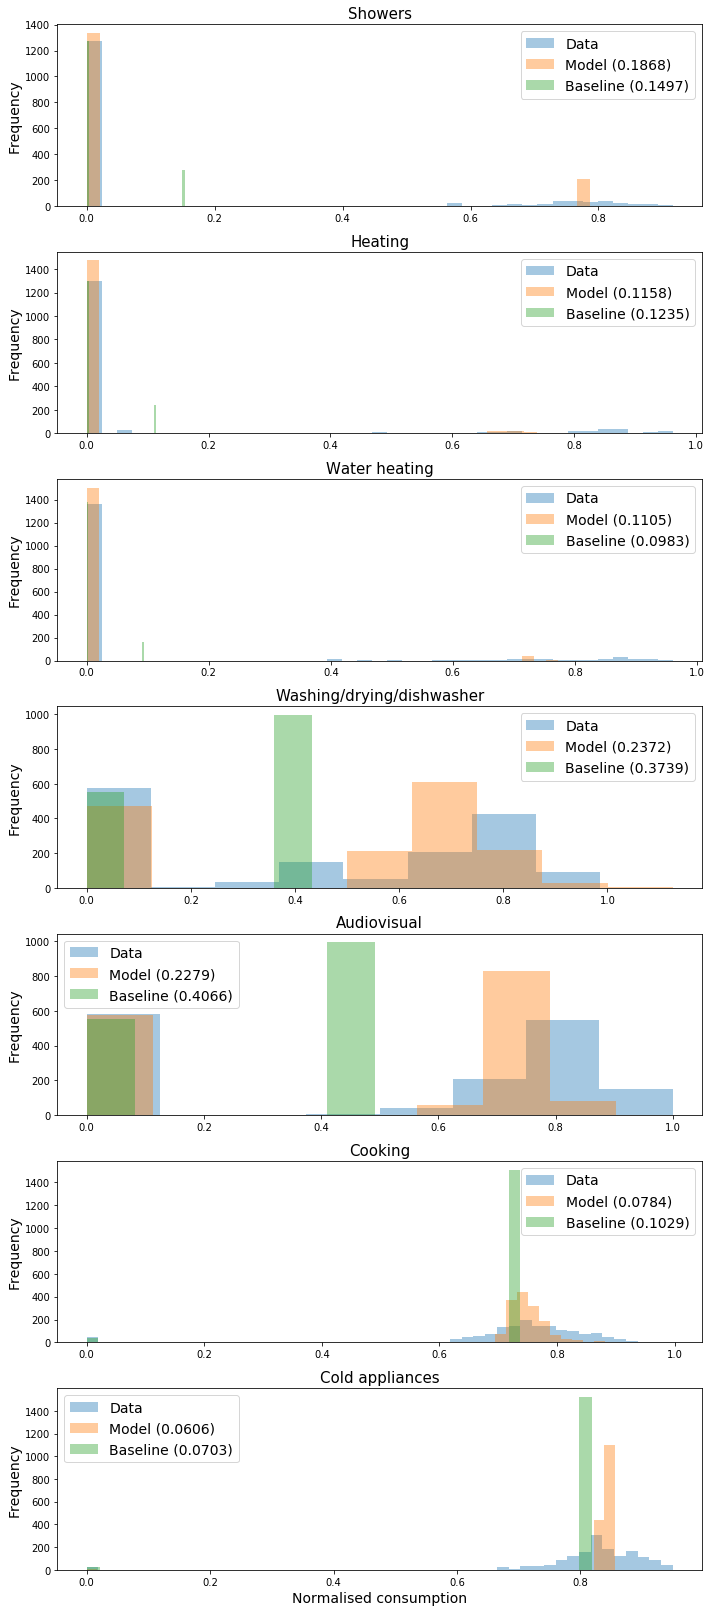

In [43]:
# plot the distribution of the test set, model and baseline
# the mean absolute error for each appliance group is in brackets in the legend
fig, ax = plt.subplots(y_test.shape[1], 1, figsize=(10, 22.5))
for i in range(y_test.shape[1]):
    model_label = "Model ({:.4f})".format(
        mean_absolute_error(y_test[:, i], y_pred[:, i])
        )
    baseline_label = "Baseline ({:.4f})".format(
            mean_absolute_error(y_test[:, i], y_baseline_better[:, i])
        )
    sns.distplot(y_test[:, i], norm_hist=False, kde=False, label="Data", ax=ax[i])
    sns.distplot(y_pred[:, i], norm_hist=False, kde=False, label=model_label, ax=ax[i])
    sns.distplot(y_baseline_better[:, i], norm_hist=False, kde=False, label=baseline_label, ax=ax[i])
    ax[i].set_title(appliances[i],fontsize=15)
    ax[i].set_ylabel("Frequency",fontsize=14)
    ax[i].legend(fontsize=14)
ax[y_test.shape[1]-1].set_xlabel("Normalised consumption",fontsize=14)
plt.tight_layout()
# plt.savefig("../doc/fig/model_results.pdf")

Text(0.5, 1.0, 'Audiovisual appliance group consumption distribution')

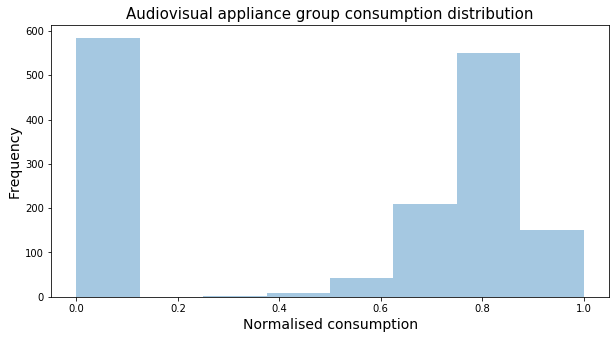

In [44]:
which_group = 4
sns.distplot(y_test[:, which_group], kde=False)
plt.xlabel("Normalised consumption", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Audiovisual appliance group consumption distribution", fontsize=15)
# plt.savefig("../doc/fig/example_distribution.pdf")

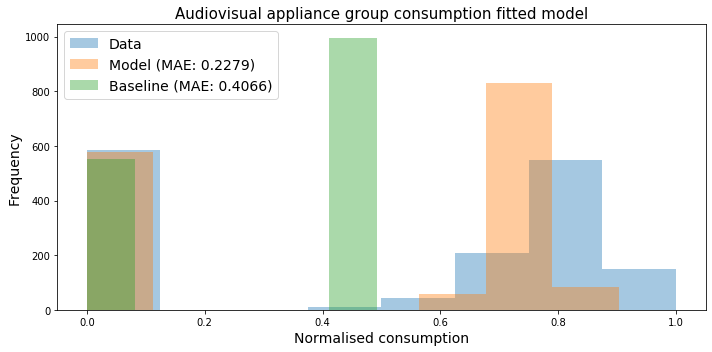

In [45]:
# plot the distribution of the test set, model and baseline
# the mean absolute error for each appliance group is in brackets in the legend
fig, ax = plt.subplots(1, 1)
model_label = "Model (MAE: {:.4f})".format(
        mean_absolute_error(y_test[:, which_group], y_pred[:, which_group])
        )
baseline_label = "Baseline (MAE: {:.4f})".format(
            mean_absolute_error(y_test[:, which_group], y_baseline_better[:, which_group])
        )
sns.distplot(y_test[:, which_group], norm_hist=False, kde=False, label="Data", ax=ax)
sns.distplot(y_pred[:, which_group], norm_hist=False, kde=False, label=model_label, ax=ax)
sns.distplot(y_baseline_better[:, which_group], norm_hist=False, kde=False, label=baseline_label, ax=ax)
ax.set_title(appliances[which_group]+" appliance group consumption fitted model",fontsize=15)
ax.set_ylabel("Frequency",fontsize=14)
ax.set_xlabel("Normalised consumption",fontsize=14)
ax.legend(fontsize=14)
plt.tight_layout()
# plt.savefig("../doc/fig/example_fitting.pdf")

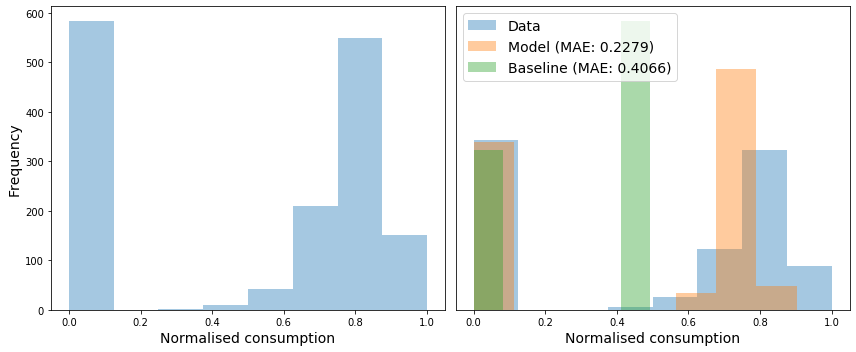

In [46]:
# Side by side

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.distplot(y_test[:, which_group], kde=False, ax=ax[0])
ax[0].set_xlabel("Normalised consumption", fontsize=14)
ax[0].set_ylabel("Frequency", fontsize=14)
#ax[0].set_title("Audiovisual appliance group consumption distribution", fontsize=15)

model_label = "Model (MAE: {:.4f})".format(
        mean_absolute_error(y_test[:, which_group], y_pred[:, which_group]))
baseline_label = "Baseline (MAE: {:.4f})".format(
            mean_absolute_error(y_test[:, which_group], y_baseline_better[:, which_group]))
sns.distplot(y_test[:, which_group], norm_hist=False, kde=False, label="Data", ax=ax[1])
sns.distplot(y_pred[:, which_group], norm_hist=False, kde=False, label=model_label, ax=ax[1])
sns.distplot(y_baseline_better[:, which_group], norm_hist=False, kde=False, label=baseline_label, ax=ax[1])
#ax[1].set_title(appliances[which_group]+" appliance group consumption fitted model",fontsize=15)
#ax[1].set_ylabel("Frequency",fontsize=14)
ax[1].set_xlabel("Normalised consumption",fontsize=14)
ax[1].yaxis.set_ticks_position('none')
ax[1].set_yticklabels([])
ax[1].legend(fontsize=14)

#plt.title("Audiovisual appliance group consumption distribution", fontsize=15)
plt.tight_layout()
# plt.savefig("../doc/fig/example_fitting_side_by_side.pdf")

In [47]:
# Table with results per appliance group

for i in range(y_test.shape[1]):
    model_label = "Model ({:.4f})".format(
        mean_absolute_error(y_test[:, i], y_pred[:, i])
        )
    baseline_label = "Baseline ({:.4f})".format(
            mean_absolute_error(y_test[:, i], y_baseline_better[:, i])
        )
    print("Group:",appliances[i])
    print("Model:",model_label)
    print("Baseline:",baseline_label)
    print("---------")

print("Size of validation data-points (Always the same of course, household/day)",y_test[:, 0].shape[0])
print("Model",mean_absolute_error(y_test, y_pred))
print("Baseline",mean_absolute_error(y_test, y_baseline_better))

Group: Showers
Model: Model (0.1868)
Baseline: Baseline (0.1497)
---------
Group: Heating
Model: Model (0.1158)
Baseline: Baseline (0.1235)
---------
Group: Water heating
Model: Model (0.1105)
Baseline: Baseline (0.0983)
---------
Group: Washing/drying/dishwasher
Model: Model (0.2372)
Baseline: Baseline (0.3739)
---------
Group: Audiovisual
Model: Model (0.2279)
Baseline: Baseline (0.4066)
---------
Group: Cooking
Model: Model (0.0784)
Baseline: Baseline (0.1029)
---------
Group: Cold appliances
Model: Model (0.0606)
Baseline: Baseline (0.0703)
---------
Size of validation data-points (Always the same of course, household/day) 1546
Model 0.145313741663142
Baseline 0.18931565155929234
